# 对比性测试

## 导入

In [1]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

JuNarsese v1.3.0


In [2]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [3]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 4


4

In [4]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [5]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

function randomSentence(depth=3, width=3)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(randomStatement(depth-1, width))
end

function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 (--, <(*, $mdjektrkmp, ^rcst, #l) --> jwoh>)
 (--, <<#ave --> ?evqu> ==> <#kvoofgy <-> (&, ^dlkfv, $zt, puzvtwcyie, ^vzmb, ?dgwvzzrw)>>)
 <(-, zbf, ?l) --> (*, $ps, njxsvby, jpsjomluzm, $fgodhldeo, #jic)>
 <[^jzabgr, ^d, $fqwt, ebegld] <-> v>@
 [(*, #plcb), (/, _, ?rty, #nz)]
 <<(\, _, ?brblilg, $cwv, #zyas) <-> hnguwfnay> ==> <^grctauuxxh --> (/, $moviqmgh, ?gu, $klbbvq, _)>>! %1.0;0.5%
 (--, <<<<thgqsjwxu --> wloqkxqqs> <=> <?fqy --> ^zrzkgkc>> <=> <$ft <-> vv>> <=> <<$wdowbwiacd <-> $qs> ==> <^ekaa <-> $pyuvf>>>)
 <(|, ?vgc) <-> (~, #knrgaacgge, ?iuc)>
 <<?qv --> (-, #kufssxaobc, $eghg)> <=> <<#ayl --> ?mxgsumtauc> <=> <<#vhun <-> wrjhpy> <=> <^tutq --> ?ndbqrbq>>>>. %1.0;0.5%
 (--, <<vbbtctlmv <-> (-, ^c, ?l)> ==> <(~, ^tvfwmyxfp, ?dkmud) <-> hy>>)

生成测试集

In [6]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 对「语句」的支持欠佳：Junars无法解析，获取语法复杂度方面存在欠缺
    for _ in 1:N
]

randomNarsese(D, W) = <<<<<<zvzlzwzrrg <-> bzmlxyao> <=> <^szt --> ?qta>> <=> <<#brpi <-> ?q> <=> <$siay <-> ^pdrs>>> ==> <(&, rx, czolzj, ?moyg) <-> ?ltxpd>> <=> <<?lawcgpuxa <-> (~, ^zmnqop, ^mjep)> ==> <<<gsp --> igi> <=> <^ofsmeiqvyu <-> p>> <=> <<^xtth --> #voemhiwshi> ==> <?vga --> #nmuhfg>>>>> ==> <$hnfcqzy <-> cwvpr>>


500-element Vector{AbstractTerm}:
 <<<<?ploeg <-> $qhqt> ==> <<^blm <-> #s> <=> <?fhb --> #jbqecuh>>> ==> <^y --> (-, $o, #dur)>> ==> <(/, <<?nr <-> ?nkg> ==> <shhf --> #yfpa>>, (~, ?zehmei, ^dbjhcw), _, (/, ^nzkhfc, $f, _), <<^mphqr --> ^wwqy> <=> <?srdw <-> #xqrygpqhm>>, (-, $i, #sd)) --> (/, <#kbxew --> ^exlqgii>, _, (~, p, ?vbzr))>>
 <?msnvqilgzq --> (&, (~, (-, #js, csll), (&, lonqyr, ?ivk, $gxbvvwkfqv)), <(/, $ldr, $u, ^pn, _, ^bp, ^kio) --> $jw>, {(-, bnee, ?ysk), (--, <<viq <-> ^y> ==> <^esudfge --> $cn>>)}, <?mthwijsmzh <-> (~, ajadktf, zkwqkb)>, (--, <#rozj --> #gapaudwud>))>
 (--, <<<$ygfirjq <-> (/, bi, _, $obwpqqymzs)> <=> <^ukzkf <-> {$njqe, ylowhuv, ^xbh, #ybxvyuvqqh, c}>> <=> <zb --> ^m>>)
 {(~, (/, (--, <^psx <-> #xtiooqyum>), (~, $uavloccexu, $z), <<da --> mkunthetcv> <=> <#hnjjsefh --> #qccxdldwf>>, _), (--, <(&, vakppuesj, ?awxl) --> (|, bhfdqct, ?ygeq, ^qcbpxbbvjl)>)), (--, <<<<#zqvllfe --> $xvxkgrhc> ==> <<lsrdlc --> ^pcto> <=> <?phwvnizim <-> #vs>>> <=> <[$nz, $f

## 评估函数

#### 导入数据分析工具：DataFrames

In [7]:
using DataFrames

测试：使用具名元组直接添加行

In [8]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


#### 构造测试用表

In [9]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

500×2 DataFrame
 Row │ original_term                      string                            
     │ AbstractTerm                       String                            
─────┼──────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮
 494 │ <<^ri --> wnbxs> ==> <(/, _, <bn…  <<^ri --> wnbxs> ==> <(/, _, <bn…
 495 │ (|, (-, (-, (--, <$grk <-> wadqj…  (|, (-, (-, (--, <$grk <-> wadqj…
 496 │ (~, (\\, <<<bnt <-> ^ehmmswo> ==…  (~, (\\, <<<bnt <-> ^ehmmswo> ==…
 497 │ (--, <<<?myqwkbxtqq --> (/, qmsw…  (--, <<<?myqwkbxtqq --> (/, qmsw…
 498 │ (~, (-, (~, <<xrc --> gyvno> ==>…  (~, (-, (~, <<xrc --> gyvno> ==>…
 499 │ (/, {<(\\, ^a, _) <-> {^tq, ^arg…  (/, {<(\\, ^a, _) <-> {^tq, ^arg…
 500 │ <<{<?gcbtqp <-> $ovxkp>} --> ^qz…  <<{<?gcbtqp <-> $ovxkp>} --> ^qz…
                                                            485 rows omitted

In [10]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

500×3 DataFrame
 Row │ original_term                      string                             c ⋯
     │ AbstractTerm                       String                             I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…    ⋯
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…    ⋯
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮                    ⋱
 494 │ <<^ri --> wnbxs> ==> <(/, _, <bn…  <<^ri --> wnbxs> ==> <(/, _, <bn…    ⋯
 495 │ (|, (-, (-, (--, <$grk <-> wadqj…  (|, (-, (-, (--, <$grk <-> wadqj…
 496 │ (~, (\\, <<<bnt <-> ^ehmmswo> ==…  (~, (\\, <<<bnt <-> ^ehmmswo> ==…
 497 │ (--, <<<?myqwkbxtqq --> (/, qmsw…  (--, <<<?myqwkbxtqq --> (/, qmsw…
 498 │ (~, (-, (~, <<xrc --> gyvno> ==>…  (~, (-, (~, <<xrc --> gyvno> ==>…    ⋯
 499 │ (/, {<(\\, ^a, _) <-> {^tq, ^arg…  (/, {<(\\, ^a, _) <-> {^tq, ^arg…
 500 │ <<{<?gcbtqp <-> $ovxkp>} --> ^qz…  <<{<?gcbtqp <-> $ovxkp>} --> ^qz…
                                                   1 column and 485 rows omitted

#### 增加「特殊语法」：更能体现出解析器通用性的语法

1. 无连接符复合词项⇒乘积：`(A, B)`⇔`(*, A, B)`

In [11]:
# 无连接符复合词项⇒乘积 #
# 📝直接使用「布尔索引」对切片进行操作

# 使用 map() 函数对 test_set_extra1 中的 string 列进行操作，返回一个新数据表
# 将其中符合正则表达式 r"\(\*\W*," 的字符串替换为 "(*,"
test_set_extra1_string = map(test_set.string) do x
    replace(x, r"\(\*\W*," => "(*,")
end

# 使用「布尔索引」来选择不等于原始 string 列的值
# 并将这些值替换为经过操作后的新值
# 注意：.≠ 运算符用于逐元素比较两个数组，生成一个布尔型数组
# test_set_extra1.string[test_set_extra1! .≠ test_set_extra1.string] = test_set_extra1![test_set_extra1! .≠ test_set_extra1.string]

#【20230819 20:07:04】现在直接把「能改成新格式」的数据增加到主数据集中
indices = test_set_extra1_string .≠ test_set.string # 索引：只获取「会被改变的词项」

test_set_extra1 = test_set[indices, :] |> deepcopy

test_set_extra1.string = test_set_extra1_string[indices]

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra1
]

559×3 DataFrame
 Row │ original_term                      string                             c ⋯
     │ AbstractTerm                       String                             I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…    ⋯
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…    ⋯
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮                    ⋱
 553 │ <(-, (*, (--, <ehvenj <-> ?bjx>)…  <(-, (*, <ehvenj <-> ?bjx>), (--…    ⋯
 554 │ [<(&, (--, <iaozejb <-> $fv>)) <…  [<(&, (--, <iaozejb <-> $fv>)) <…
 555 │ (|, (--, <<rbfsvjh <-> ^vt> <=> …  (|, (--, <<rbfsvjh <-> ^vt> <=> …
 556 │ (\\, <(\\, _, (--, <<ftqyd --> ?…  (\\, <(\\, _, (--, <<ftqyd --> ?…
 557 │ (*, (-, <<^xtdqecbf --> ^awtdquh…  (*, <<^xtdqecbf --> ^awtdquhtlo>…    ⋯
 558 │ (--, <(\\, _, <<<#lr <-> ?dhbqko…  (--, <(\\, _, <<<#lr <-> ?dhbqko…
 559 │ <(/, (-, <^ictqja --> #lts>, [#g…  <(/, (-, <^ictqja --> #lts>, [#g…
                                                   1 column and 544 rows omitted

2. 随机添加空白字符：空格` `、换行`\r`、回车`\n`、换页`\f`、水平制表符`\t`、垂直制表符`\v`

In [12]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

652×3 DataFrame
 Row │ original_term                      string                             c ⋯
     │ AbstractTerm                       String                             I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…    ⋯
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…    ⋯
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮                    ⋱
 646 │ [(/, (|, (--, <^mbudcdaxog --> ?…  [(/, (|, (--, \f<^mbudcdaxog -->…    ⋯
 647 │ (-, (~, (-, (--, <<$pamexgbw <->…  (-, (~, (-, (--, <<$pamexgbw \t\…
 648 │ (--, <[(--, <$yxueckh <-> (\\, #…  (--, <[(--, \v<$yxueckh <-> \v(\…
 649 │ <<(|, (--, <b --> hde>), (|, ihf…  <<(|, \f\r(--,  <b --> hde>), (|…
 650 │ (--, <<<<<<^pdrskkmi --> $rr> <=…  (--, <<<<<<^pdrskkmi --> \n$rr> …    ⋯
 651 │ (--, <<<yzz --> [$j]> ==> <[^uez…  (--, \r<<<yzz --> [$j]> \n==> <[…
 652 │ (--, <(-, <<putjr --> $pduxburg>…  (--, <(-, <<putjr --> $pduxburg>…
                                                   1 column and 637 rows omitted

#### 构造评估函数

In [13]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [14]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set[1:100, :]))

100×6 DataFrame
 Row │ original_term                      string                             c ⋯
     │ AbstractTerm                       String                             I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…    ⋯
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…    ⋯
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮                    ⋱
  94 │ [(/, (|, (--, <^mbudcdaxog --> ?…  [(/, (|, (--, <^mbudcdaxog --> ?…    ⋯
  95 │ (-, (~, (-, (--, <<$pamexgbw <->…  (-, (~, (-, (--, <<$pamexgbw <->…
  96 │ (--, <[(--, <$yxueckh <-> (\\, #…  (--, <[(--, <$yxueckh <-> (\\, #…
  97 │ <<(|, (--, <b --> hde>), (|, ihf…  <<(|, (--, <b --> hde>), (|, ihf…
  98 │ (--, <<<<<<^pdrskkmi --> $rr> <=…  (--, <<<<<<^pdrskkmi --> $rr> <=…    ⋯
  99 │ (--, <<<yzz --> [$j]> ==> <[^uez…  (--, <<<yzz --> [$j]> ==> <[^uez…
 100 │ (--, <(-, <<putjr --> $pduxburg>…  (--, <(-, <<putjr --> $pduxburg>…
                                                   4 columns and 85 rows omitted

In [15]:
# 导入OpenJunars
isdefined(Main, :Junars) || begin
    push!(LOAD_PATH, "../../../OpenJunars/")
    import Junars
end
# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
@info "OpenJunars解析结果:" parsed_term typeof(parsed_term)

┌ Info: OpenJunars解析结果:
│   parsed_term = "<A-->B>"
│   typeof(parsed_term) = Junars.Gene.Inheritance
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\comparative_tests.ipynb:9


In [16]:
testParser!(Junars.parse_term, copy(test_set[1:100, :]))

100×6 DataFrame
 Row │ original_term                      string                             c ⋯
     │ AbstractTerm                       String                             I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ <<<<?ploeg <-> $qhqt> ==> <<^blm…  <<<<?ploeg <-> $qhqt> ==> <<^blm…    ⋯
   2 │ <?msnvqilgzq --> (&, (~, (-, #js…  <?msnvqilgzq --> (&, (~, (-, #js…
   3 │ (--, <<<$ygfirjq <-> (/, bi, _, …  (--, <<<$ygfirjq <-> (/, bi, _, …
   4 │ {(~, (/, (--, <^psx <-> #xtiooqy…  {(~, (/, (--, <^psx <-> #xtiooqy…
   5 │ (--, <(/, _, (--, <<<?exss --> ?…  (--, <(/, _, (--, <<<?exss --> ?…    ⋯
   6 │ <<<<<<atl <-> ^uvyojsrjv> <=> <$…  <<<<<<atl <-> ^uvyojsrjv> <=> <$…
   7 │ (--, <<<<^yt <-> $iqb> ==> <<$q …  (--, <<<<^yt <-> $iqb> ==> <<$q …
   8 │ [(--, <(/, _, (--, <^tckqeyovx -…  [(--, <(/, _, (--, <^tckqeyovx -…
  ⋮  │                 ⋮                                  ⋮                    ⋱
  94 │ [(/, (|, (--, <^mbudcdaxog --> ?…  [(/, (|, (--, <^mbudcdaxog --> ?…    ⋯
  95 │ (-, (~, (-, (--, <<$pamexgbw <->…  (-, (~, (-, (--, <<$pamexgbw <->…
  96 │ (--, <[(--, <$yxueckh <-> (\\, #…  (--, <[(--, <$yxueckh <-> (\\, #…
  97 │ <<(|, (--, <b --> hde>), (|, ihf…  <<(|, (--, <b --> hde>), (|, ihf…
  98 │ (--, <<<<<<^pdrskkmi --> $rr> <=…  (--, <<<<<<^pdrskkmi --> $rr> <=…    ⋯
  99 │ (--, <<<yzz --> [$j]> ==> <[^uez…  (--, <<<yzz --> [$j]> ==> <[^uez…
 100 │ (--, <(-, <<putjr --> $pduxburg>…  (--, <(-, <<putjr --> $pduxburg>…
                                                   4 columns and 85 rows omitted

## 对比性评估开始

In [17]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term  => "Junars",
    StringParser_ascii => "JuNarsese Native",
    LarkParser_alpha   => "JuNarsese×Lerche",
    PikaParser_alpha   => "JuNarsese×PikaParser",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: 以下40项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("在参数「((*, <^ai --> ?ovze>), <^slupsq --> ?bggxvsr>, (--, <<#rqkpic <-> ?muurso> ==> <?cvo --> ^js>>), (--, <<fsagxcsuv --> ^ymdrwij> <=> <\$sueonz <-> ^hgytd>>))」中未找到像占位符位置！"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("在参数「((*, _, ?lilaw, \$nlz, \$kkbfpvqu, ^i, tt, ^heea, \$ilbqj, \$hc, jfghl), <<^xoquhvvxq <-> ^ubuue> <=> <^wwptbo --> #ope>>, <?byend --> ^isrfjz>, (--, <<\$wwtyirfp --> ?yhndepjeza> <=> <tsnvrybv <-> kpqtxgieeo>>), (--, <\$gatj --> pbfxjaln>), (-, ^plqfueqf, adhgwhi), (--, <?a <-> \$lptkd>))」中未找到像占位符位置！"), ErrorException("解析失败！match = 0"), ErrorException("解析失败！match = 0"), ErrorException("在参数「((&, (--, <#copb <-> ^djgvk>)

┌ Error: 以下147项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("非法词项名「<<\$usxwwcur-->?ytvqaivf><=><?spbv-->?iyd>>),(--」！"), ErrorException("非法词项名「(*,<<^foow-->\$dqpnwe><=><\$k-->\$dibslosn>>)),(--」！"), MethodError(convert, (Statement, nothing), 0x0000000000008330), ErrorException("非法词项名「<<^ixfc-->?yebweiue>==><?fox<->^mbbc>>),(--」！"), ErrorException("非法词项名「<<?nni<->nmxoehyh>==><#pwpeigf<->^njsbux>>)」！"), ErrorException("在参数「((*, <^ai --> ?ovze>), <^slupsq --> ?bggxvsr>, (--, <<#rqkpic <-> ?muurso> ==> <?cvo --> ^js>>), (--, <<fsagxcsuv --> ^ymdrwij> <=> <\$sueonz <-> ^hgytd>>))」中未找到像占位符位置！"), ErrorException("非法词项名「{(-,(--,<<r<->^xkxuu>==><a-->#ajdlzzr>>),[\$nss,wmlovw]),<<<^bpkovp-->#tii><=><qfvewenxw-->\$md>><=><<kjybzndh<->#zd><=><?doftcc-->\$eyuowp>>>,(/,<<?svzrve<->^yhzij><=><wgwuo-->^zsscrn>>,(/,#aaji,\$yche,_,^crgvketmm),<<aqd<->\$tnf>==><\$zvscn<->#dfk>>,(*,\$xzreefrb,\$nb,dgyzfgzopx,?sugogb,?ibmubzm,\$qecditlly,#ucwejl,#rrjfgzrw,?ouo),(--,<?zsquirhq<->^w>),(--,<?slb

┌ Error: Invalid input! <<$usxwwcur-->?ytvqaivf><=><?spbv-->?iyd>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?spbv-->?iyd>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?taarq<->t><=><$pqdr-->xhi>>))<->ud>,(--,<<<(*,kl,x)<->^wgmd><=><?ehoeojp-->(\,_,$qnzujthjy)>><=><#jbt-->?mvtoa>>),(/,(-,(/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$pqdr-->xhi>>))<->ud>,(--,<<<(*,kl,x)<->^wgmd><=><?ehoeojp-->(\,_,$qnzujthjy)>><=><#jbt-->?mvtoa>>),(/,(-,(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#ur-->?wgfelzed><=><?offh-->#i>>)),(-,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ E

┌ Error: Invalid input! <(\,_,veqpf)-->(*,^hhoksnl,#bdbyfom,bza,a)>),(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,^hhoksnl,#bdbyfom,bza,a)>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (-,?mcxav,?theoevdzk)),<{tkvvc,#dmllj,^klhsk,#vgnhuiwvd,$jkhthzgv}-->$edaqe>,(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <(*,<#slbqsjxg<->y>),<$b<->?rrrj>,(*,$r),<#vjmtqhvx-->$balq>,(\,^nczat,_,$cwktuqbs))-->$e>,(&
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! <<#oq-->$oflj>==><?km-->oqsgoiojgj>>)
└ @ 

┌ Error: Invalid input! (|,dytazhzowy,?wzrmlhgj)>)),(--,<<<^qssecgs<->#jteylus>==><<^keamnrzjm<->?cqgnxqd>==><<$utgmymjcu-->nfytjik><=><$atgocqtqc-->^ctfpaxri>>>>==><{aqekod,$bqbvejuko,$wnjp,hixbinodbb,t}-->(&,$xnpwr,?vm,^jcf,#exawd)>>),<^p-->(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <?geft-->(*,<kninygvdqn<->pps>),_)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,<kninygvdqn<->pps>),_
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <kninygvdqn<->pps>),
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<t<->^rademrnqo>==><$bb-->dghg>>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Inv

┌ Error: Invalid input! (--,<uqwwn-->{#xbpwuuuabl,$a}>)),<^ysacbagu-->(/,_,(-,^tfm,gzf),<$jwi<->#tjoznw>)>,_,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <uqwwn-->{#xbpwuuuabl,$a}>)),<^ysacbagu-->(/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! <$jwi<->#tjoznw>)>,_,(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<^nwospcmav<->{#quhaoj,^hvsj,^y,e,uuopldjf}>==><<#vuuld<->?ovbfmw><=><^wkqsvmlzuz<->yjdfmkd>>>==><(~,#wghshsl,?hmijskxxl)-->{$bhhq,bjge,#wc}>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid ExtSet Input!
└ @ Juna

┌ Error: Invalid input! (--,<<^b<->#pfqskooc>==><<$ubdult<->^ysqsrnlfg><=><?ugnogfubo-->?zbvxacx>>>)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<^b<->#pfqskooc>==><<$ubdult<->^ysqsrnlfg><=><?ugnogfubo-->?zbvxacx>>>)),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<$ubdult<->^ysqsrnlfg><=><?ugnogfubo-->?zbvxacx>>>)),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?ugnogfubo-->?zbvxacx>>>)),
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(\,_,^vieosdfhzl,#dm)<->(-,viztei,^ysnhltxia)>>>),<rthhq-->(*,<<?fgzawbwo<->#l><=><^ptya-->dmdki>>,<?h<->$bxlra>,(--,<<$foqmhfy-->#xfsdqbhxpz>==><^wkd<->?qgexrabrx>>),<#dq<->#nmvqf>,(/,uorken,_,$ilvyzfnzkl,#nopu

┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (--,<<<?jauezntpa-->^hkaqxeh>==><?wdkjftei<->?htzevhd>><=><<^lijtdvdtjm-->#hwuwm>==><#kkgla-->?zpllvf>>>)),(\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<?jauezntpa-->^hkaqxeh>==><?wdkjftei<->?htzevhd>><=><<^lijtdvdtjm-->#hwuwm>==><#kkgla-->?zpllvf>>>)),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<^lijtdvdtjm-->#hwuwm>==><#kkgla-->?zpllvf>>>)),
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <#kkgla-->?zpllvf>>>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#xeytt

┌ Error: Invalid input! <<<^yt
#hfcthffv>==><#pisj<->^jto>>><=>
│ <(&,$vkmkfug)-->$p>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?goualyxqhr<->(/,sgfo,$adkmiabcs,_,dfbqt)>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (/,sgfo,$adkmiabcs,_,dfbqt)>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (|,?bqg,?ab,#yvhuv,^gykmxrncl)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <(*,kl,x)<->^wgmd>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,kl,x)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invali

$hmpjxretr,^vtkyz)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <^csuypm-->(~,$vzdme,xzw)>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (~,$vzdme,xzw)>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <^rcbn<->vjcg>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <sialwdj<->^qyoa>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
-->#kz>==><^qkvsjyzjwo-->	?ini>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <#wtvbt-->qmmfeyqiac>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese

┌ Error: 以下79项解析错误：
│   errors = Union{Missing, Exception}[MethodError(nextind, ("(*,\$y,?u),(--,<^khgcow<->^byfcpswvaj>),(-,xs,dsvoxx))<->\$b", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,<#slbqsjxg<->y>),<\$b<->?rrrj>,(*,\$r),<#vjmtqhvx-->\$balq>,(\\,^nczat,_,\$cwktuqbs))-->\$e>,(", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,<<?vfeghifpww-->?gcidcz><=><qnrysvwb-->^dykqiueelz>>),<<#lalyawc-->^oegjfoa><=><yurxjthd-->?vdqdmae>>,(--,<<oovwpuhjdc-->\$oqk>==><\$dgmnqt<->\$bvkmoebemm>>),<<^okymtll-->^fxcipd>==><\$grcahtlj-->wzjcfk>>)<->(-,(-,#wkcibd,#gmgucyl),(--,<t<->l>))", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,<<#yu-->?afkummtoel><=><xsebsdnmh<->\$fjomn>>),<weixf<->#zxpyylmhd>,<?kzowsbm<->?zw>)-->(\\,<<kzpxezxxpc<->^x><=><?vjrylcbj-->tlr>>,_,(--,<<?u-->\$opl>==><?dzibkjmfsn-->\$dkf>>))>),(", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,<<xzkzct<->^zwdhs>==><^vl-->\$ckugbzi>>),(--,<^kl-->\$kuckoapwa>),(\\,?hfbse,?dbmidg,

┌ Error: 以下206项解析错误：
	), ["MINUS", "MORETHAN", "RBRACE", "TILDE", "AMPERSAND", "DOT", "BANG", "QMARK", "AT", "RSQB", "STAR", "RPAR", "COMMA", "VBAR"], 2, 121, nothing, 79, 160, nothing, false), Lerche.UnexpectedToken(Token(VBAR, |), ["PLUS", "LPAR", "QMARK", "HASH", "LBRACE", "CIRCUMFLEX", "DOLLAR", "LSQB", "LESSTHAN"], 1, 207, nothing, 103, 207, nothing, false), Lerche.UnexpectedToken(Token(QMARK, ?), ["RPAR", "RBRACE", "COMMA", "RSQB"], 1, 19, nothing, 27, 19, nothing, false), Lerche.UnexpectedToken(Token(LESSTHAN, <), ["MINUS", "MORETHAN", "LPAR", "RBRACE", "TILDE", "AMPERSAND", "DOT", "BANG", "QMARK", "AT", "RSQB", "STAR", "RPAR", "COMMA", "VBAR"], 2, 147, nothing, 219, 169, nothing, false), Lerche.UnexpectedToken(Token(LESSTHAN, <), ["MINUS", "MORETHAN", "LPAR", "RBRACE", "TILDE", "AMPERSAND", "DOT", "BANG", "QMARK", "AT", "RSQB", "STAR", "RPAR", "COMMA", "VBAR"], 1, 32, nothing, 219, 32, nothing, false), Lerche.UnexpectedToken(Token(CIRCUMFLEX, ^), ["MINUS", "MORETHAN", "LPAR", "

Dict{Any, Any} with 4 entries:
  PikaParser_alpha   => 652×6 DataFrame…
  StringParser_ascii => 652×6 DataFrame…
  parse_term         => 652×6 DataFrame…
  LarkParser_alpha   => 652×6 DataFrame…

## 比对结果分析、展示

In [18]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [19]:
print("解析成功的数据：")
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

解析成功的数据：

4-element Vector{Pair{_A, Int64} where _A}:
          PikaParser_alpha => 612
        StringParser_ascii => 505
 Junars.Control.parse_term => 573
          LarkParser_alpha => 446

In [20]:
using CairoMakie

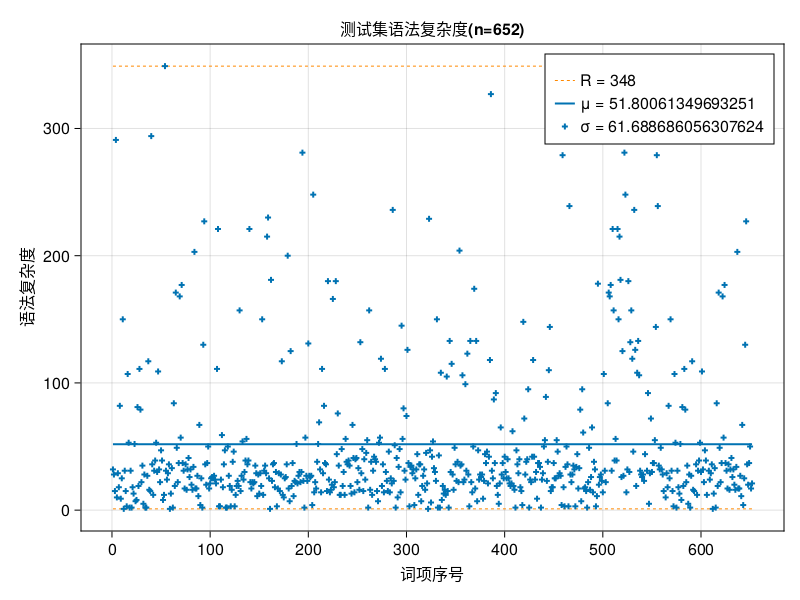

In [24]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度(n=$(size(test_set, 1)))"
ax.xlabel = "词项序号"
ax.ylabel = "语法复杂度"

current_figure()

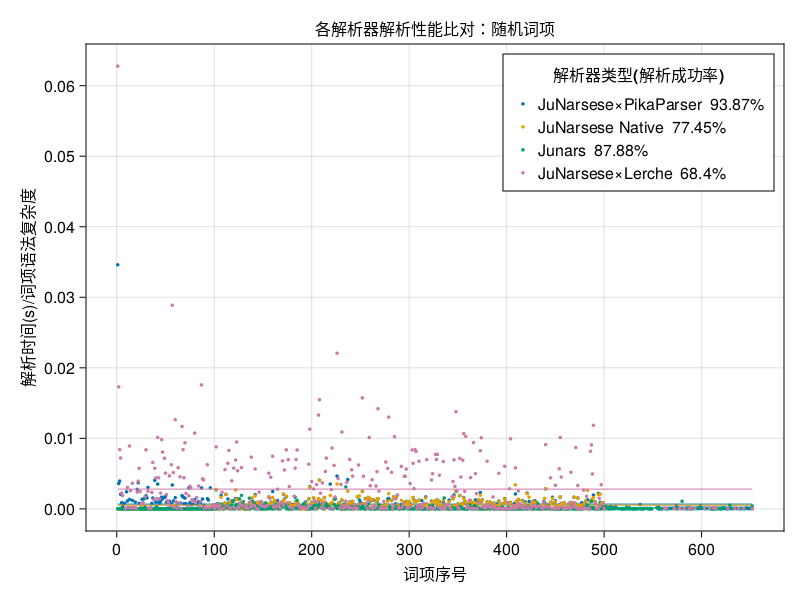

In [22]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

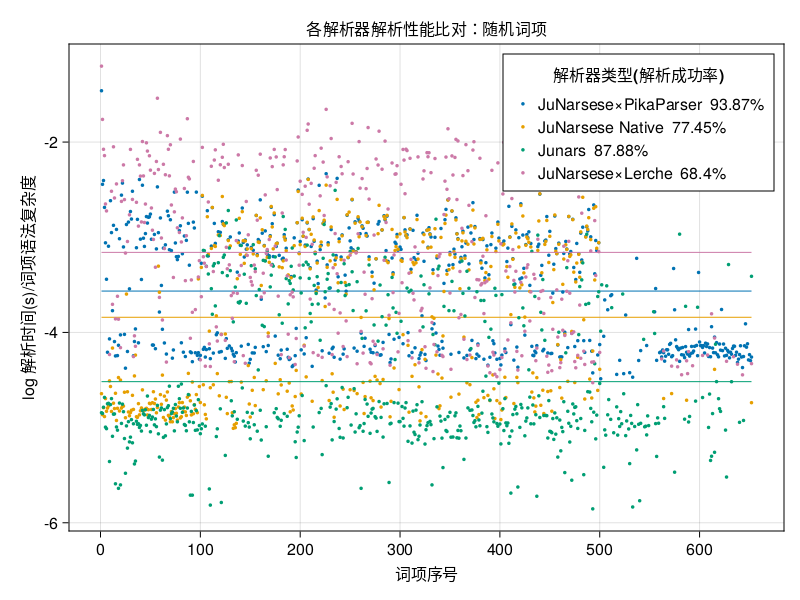

In [23]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()